In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import *


# Loading Data, splitting into train, validation(dev) and test


In [2]:
obj = pd.read_pickle('/kaggle/input/applied-ass2/ass2.pickle')
train,dev,test = obj['train'],obj['dev'],obj['test']
train = train.reset_index(drop=True)
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f33,f34,f35,f36,f37,f38,f39,f40,f41,target
0,1,0,0,0,0,0,2,1,2,2,...,0,0,0,2,0,0,0,0,0,2
1,0,0,0,0,0,0,2,1,0,0,...,0,0,0,2,0,0,0,0,0,2
2,2,1,2,1,1,0,2,2,0,0,...,0,0,0,1,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2
4,0,0,0,0,0,0,1,1,2,0,...,0,0,0,2,1,2,0,0,0,2


[2 1 0]
target
0     3917
1     9882
2    26734
dtype: int64


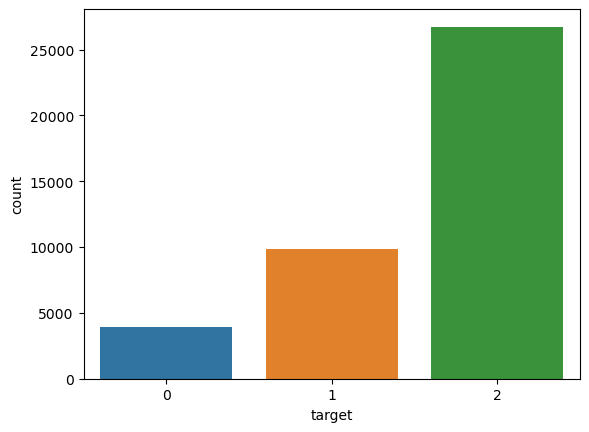

In [3]:
print(train['target'].unique())
print(train.groupby('target').size())
sns.countplot(x='target', data=train)
plt.show()

# Correlation matrix - Heatmap

<AxesSubplot:>

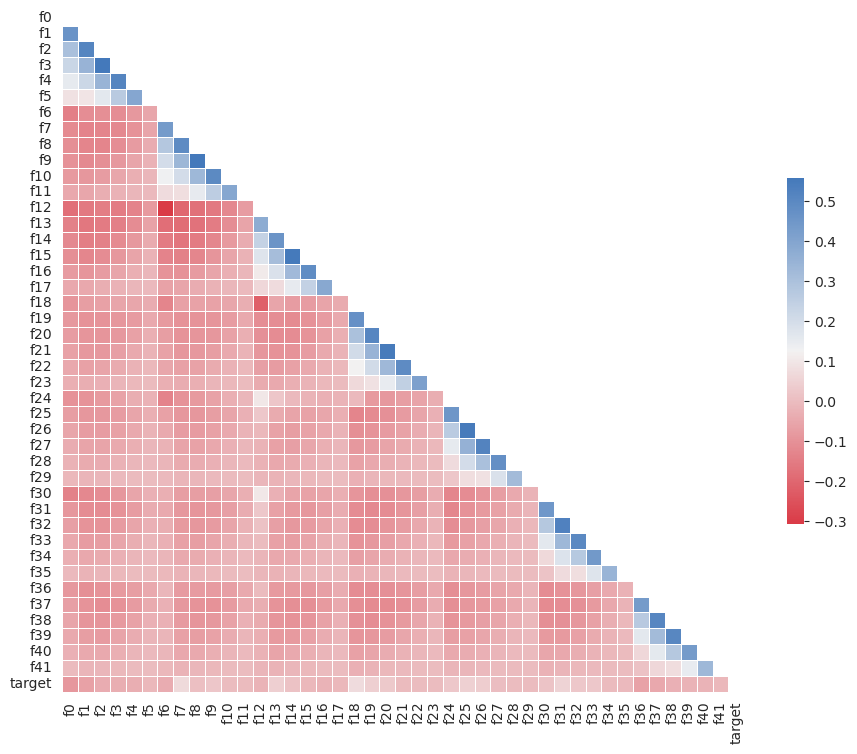

In [4]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Train and Target separation

In [5]:
X_train, X_test = train.loc[:, train.columns != 'target'] ,dev.loc[:, dev.columns != 'target']
y_train, y_test =  train['target'], dev['target']

# Training RF and validation top feature importance

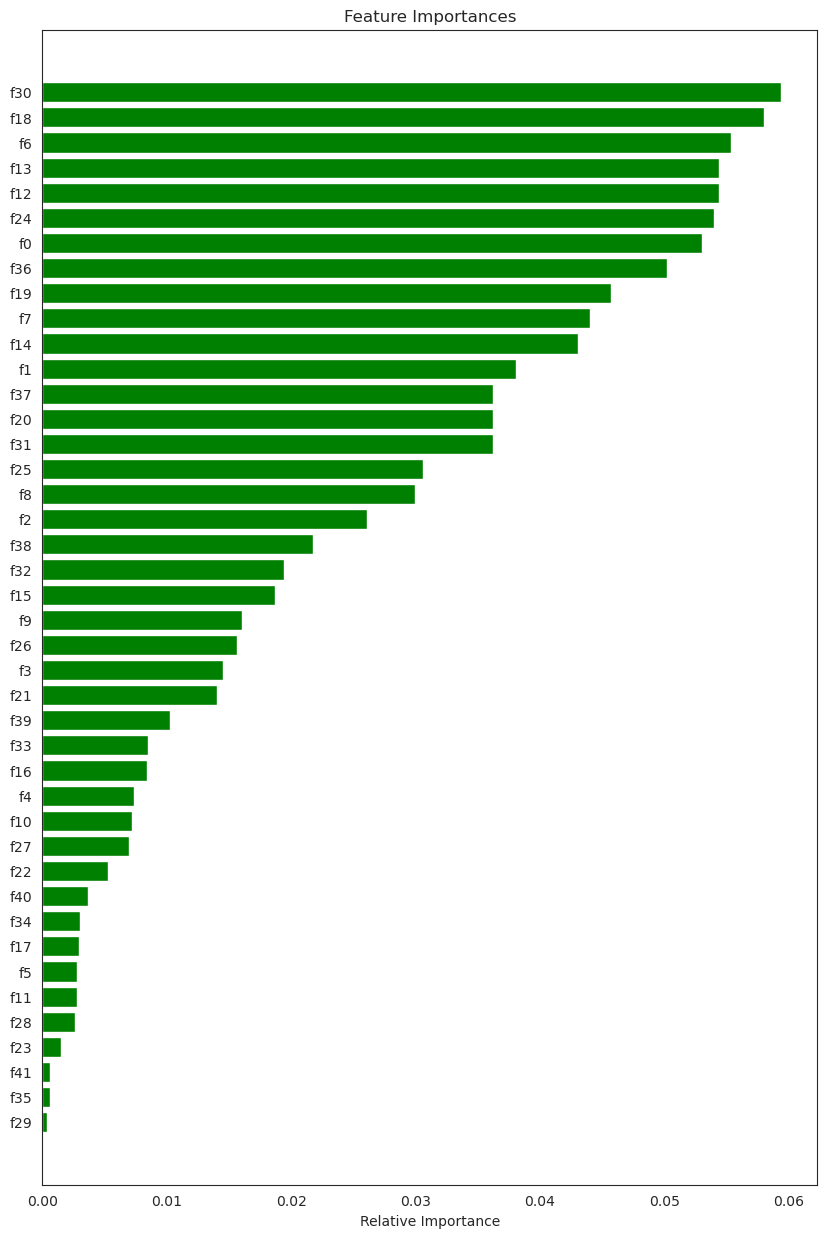

In [6]:
# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
# plotting feature importances
features = train.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Defining different models and hyper params

In [7]:
models_to_params = [
    (GradientBoostingClassifier(), 
    {   'model__learning_rate': [0.01,0.02,0.03],
        'model__subsample'    : [0.9, 0.5, 0.2],
        'model__n_estimators' : [100,250,500],
        'model__max_depth'    : [4,6,8]}),
    (RandomForestClassifier(),
     {'model__n_estimators': [100, 200, 300], 
      'model__max_depth': [5, 10]}),
    (SVC(),
     {'model__C': [0.1, 0.5 ,1, 5 ,10], 
      'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}),
    (KNeighborsClassifier(),
     {'model__n_neighbors': [2, 5, 7 ,10, 15 ,20], 
      'model__weights': ['uniform', 'distance']}),
    (GaussianNB(), {
        'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    })
]

# defining pre proccessing parameters
# select k best feature according to f_regresssion or PCA
pre_to_params = [(SelectKBest(f_regression), {'pre__k':[20,25,27,30,33,35,38,40]}),
                 (PCA() , {'pre__n_components': [5, 10, 20]})]

# RandomizedSearchCV for best estimators and hyperparams

In [8]:
pipelines = []
for model, model_params in models_to_params:
    for pre, pre_params in pre_to_params:
        pipeline = Pipeline(
        [
         ('pre',pre),
         ('model',model)
        ]
        )
        params = {**pre_params, **model_params}
        clf = RandomizedSearchCV(estimator = pipeline, param_distributions = params, cv=5, scoring="accuracy")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(str(model).split('(')[0], 'Metrics:')
        model_accuracy_score = accuracy_score(y_test, y_pred)
        print('Accuracy:', model_accuracy_score)
        model_f1_score = f1_score(y_test, y_pred, average='weighted')
        print('F1-score:', model_f1_score)
        print('Best hyperparameters:', clf.best_params_)
        
        pipelines.append((model_accuracy_score, clf.best_estimator_))
        
        results = pd.DataFrame(clf.cv_results_['params'])
        results['mean_test_score'] = clf.cv_results_['mean_test_score']
        # print the results in a table format
        print(results.to_string(index=False))
        print('=======================================')

GradientBoostingClassifier Metrics:
Accuracy: 0.8411782119597395
F1-score: 0.821698556791385
Best hyperparameters: {'pre__k': 35, 'model__subsample': 0.9, 'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.02}
 pre__k  model__subsample  model__n_estimators  model__max_depth  model__learning_rate  mean_test_score
     33               0.5                  100                 6                  0.02         0.742062
     30               0.5                  250                 6                  0.01         0.748797
     27               0.5                  100                 4                  0.03         0.722646
     40               0.9                  100                 8                  0.03         0.793427
     40               0.9                  500                 4                  0.03         0.787235
     40               0.2                  100                 6                  0.03         0.763477
     35               0.5           

# Building ensemble with top 3 estimators - Validation on validation set

In [9]:
from sklearn.ensemble import VotingClassifier

# the three best models
sorted_pipelines = sorted(pipelines, key=lambda x: x[0], reverse=True)
top_3_pipelines = [(str(i),x[1]) for i,x in enumerate(sorted_pipelines[:3])]
print(top_3_pipelines)

# Create the ensemble model using voting
ensemble = VotingClassifier(estimators = top_3_pipelines, voting='hard')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

[('0', Pipeline(steps=[('pre',
                 SelectKBest(k=35,
                             score_func=<function f_regression at 0x73ecea4a9c20>)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.02, max_depth=8,
                                            n_estimators=500, subsample=0.9))])), ('1', Pipeline(steps=[('pre',
                 SelectKBest(k=33,
                             score_func=<function f_regression at 0x73ecea4a9c20>)),
                ('model', SVC(C=10))])), ('2', Pipeline(steps=[('pre',
                 SelectKBest(k=35,
                             score_func=<function f_regression at 0x73ecea4a9c20>)),
                ('model',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))]))]
Accuracy: 0.8230461811722913
F1-score: 0.7991925386083144


# Applying ensemble on test set

In [10]:
X_test_set = test.loc[:, train.columns != 'target']
y_test_set =  test['target']

y_pred = ensemble.predict(X_test_set)

print('Accuracy:', accuracy_score(y_test_set, y_pred))
print('F1-score:', f1_score(y_test_set, y_pred, average='weighted'))

Accuracy: 0.8161634103019538
F1-score: 0.7914272426866937
